In [ ]:
from functools import partial

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import Lorenz63, solve_ode
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.models import NeuralODE
from dynamics_discovery.preprocessing import standardize, split_into_chunks
import dysts
from matplotlib_utils.axes_setters import set_labels

jax.config.update("jax_enable_x64", True)

In [2]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")

u_train_test = dataset_loaded.u
u_train_mean = jnp.mean(u_train_test[0], axis=0)
u_train_std = jnp.std(u_train_test[0], axis=0)
u_train_test_norm = (u_train_test - u_train_mean) / u_train_std

u_train, u_test = u_train_test_norm

In [ ]:
neuralode = NeuralODE(3, 32, 3)

In [30]:
model = eqx.tree_deserialise_leaves("./results/lorenz_length=2_key=0.eqx", neuralode)
u_pred = solve_ode(model, dataset_loaded.t, u_test[0], max_steps=None)

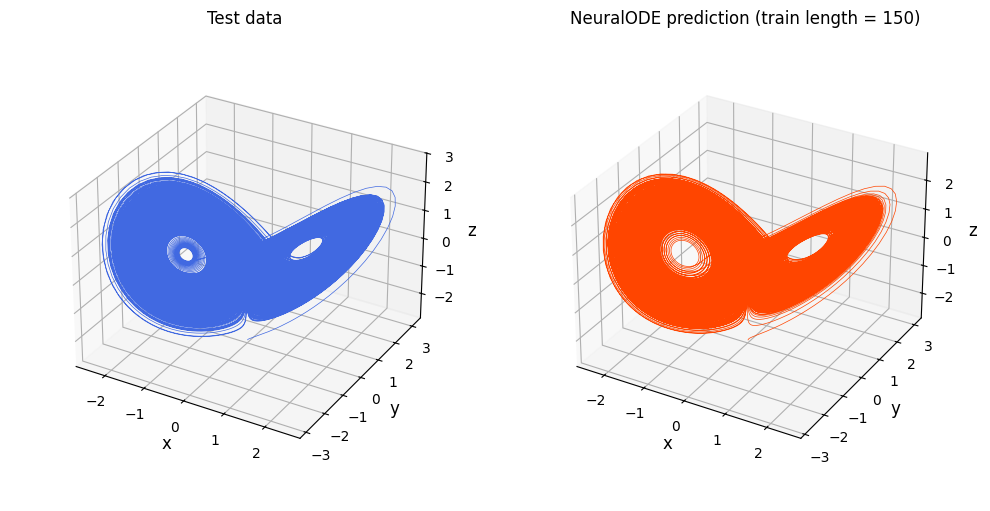

In [31]:
chunk_length = 150
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].plot(*u_test.T, color="royalblue", **plot_kwargs)
axes[0].set_title("Test data")
axes[1].plot(*u_pred.T, color="orangered", **plot_kwargs)
axes[1].set_title(f"NeuralODE prediction (train length = {chunk_length})")
for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)

In [22]:
u_pred.shape

(100000, 3)

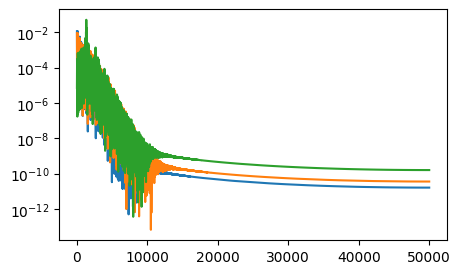

In [40]:
from jaxtyping import Float, Array
from tqdm import tqdm


def normalized_fft_intensity(x: Float[Array, "time dim"]):
    x_fft = jnp.fft.rfft(x, axis=0, norm="ortho")
    intensity = jnp.abs(x_fft) ** 2
    return intensity / jnp.sum(intensity, axis=0)


@jax.jit
def hellinger_dim(u_true, u_pred):
    intensity_true = normalized_fft_intensity(u_true)
    intensity_pred = normalized_fft_intensity(u_pred)
    integral_pq = jnp.trapezoid(jnp.sqrt(intensity_true * intensity_pred), axis=0)
    return jnp.mean(1 - integral_pq)


u_intensity = normalized_fft_intensity(u_test)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(u_intensity)
ax.set_yscale("log", base=10)

In [46]:
u_preds = []
batch_lengths = jnp.asarray([2, 10, 20, 50, 77, 100, 150, 200])
for seed in (0, 10, 20):
    u_pred_i = []
    for length in tqdm(batch_lengths):
        model = eqx.tree_deserialise_leaves(
            f"./results/lorenz_length={length}_key={seed}.eqx", neuralode
        )
        u_pred = solve_ode(model, dataset_loaded.t, u_test[0], max_steps=None)
        u_pred_i.append(u_pred)
    u_preds.append(jnp.asarray(u_pred_i))

100%|██████████| 8/8 [01:23<00:00, 10.40s/it]


In [48]:
u_preds = jnp.asarray(u_preds)
u_preds.shape

(3, 8, 100000, 3)

In [45]:
models = [
    eqx.tree_deserialise_leaves(
        f"./results/lorenz_length={length}_key=0.eqx", neuralode
    )
    for length in batch_lengths
]
model_stacked = jax.tree.map(lambda *args: jnp.stack(args, axis=0), *models)

TypeError: stack requires ndarray or scalar arguments, got <class 'function'> at position 0.

In [50]:
hellinger = jax.vmap(jax.vmap(hellinger_dim, in_axes=(None, 0)), in_axes=(None, 0))(
    u_test, u_preds
)

In [51]:
hellinger.shape

(3, 8)

<ErrorbarContainer object of 3 artists>

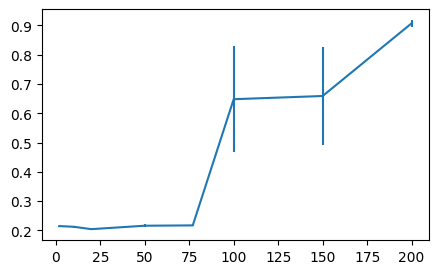

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.errorbar(
    batch_lengths,
    jnp.mean(hellinger, axis=0),
    yerr=jnp.std(hellinger, axis=0) / jnp.sqrt(3),
)

In [42]:
hellinger

[Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32),
 Array(0.21188132, dtype=float32)]